# Markov Decision Processes: Solution by Value Iteration with Maximum Entropy


Value iteration is an __exact__ solution method to a Markov decision process.  It has convergence gaurantees, and produces the optimal __value function__ $V$. Here, value iteration is extended with a __maximum entropy__ regularization, which seeks to make the policy as non-deterministic as possible by considering the policy as a probability distribution and maximizing its entropy. The policy solution thus becomes in-exact. 


A Markov decision process is defined by:


+ $S$ : a set of states 
+ $A$ : a set of actions 
+ $H$ : a finite time horizon $i=1, ..., H$ 
+ $T$ : $S \times A \times S \times \{1,...,H\} \rightarrow [0,1]$ a transition probability function $P(s_{t+1} = s' | s_t = s, a_t = a)$
+ $R$ : $S \times A \times S \times \{1,...,H\} \rightarrow \mathbb{R}$ a reward function $R(s,a,s')$

+ $\gamma$: a discount factor. 

The desired result is an optimal policy $\pi^{*}: S \times \{0,...,H\} \rightarrow A$ which describes the optimal action $a^{*}$to be undertaken for each state $s$. 

Alternatively, to find $\pi$ such that the expected discounted rewards are maximized:

$$ \text{max}_{\pi} E[\sum_{t=0}^{H}\gamma^{t} R(s_{t},a_t,s_{t+1})| \pi]$$

Under the _maxmimum entropy_ formalism, the optimal corresponds to the maximum expected reward _regularized by the entropy of the policy distribution for a given state_:

$$ \text{max}_{\pi} E[\sum_{t=0}^{H} r_t + \beta\mathcal{H}(\pi(\cdot | s_t))]$$


Through a derivation similar to the constrained optimization derivation of the Boltzmann distribution in statistical mechanics, the maximum entropy formalism can be applied to value iteration.

### Value Iteration Algorithm with Maximum Entropy

Note that in value iteration with maxmimum entropy, the policy $\pi_(a|s)$ is a _distribution_ over actions in a given state. 

Here, the partition function $Z=Z(s)$ is given by:

$$ Z(s) = \sum_{a} exp \left( \frac{1}{\beta}r(s,a) \right) $$


1. Start with $V^{*} = 0$ for all $s$:
2. For i = 1, ..., H: 
    2. For all states $s$ in $S$:
    
    $Q_{i+1}(s,a) \leftarrow E\left [ r(s,a) + V_{i}(s') \right]$
    
    $V_{i+1}(s) \leftarrow \beta \text{log} \sum_{a} exp(\frac{1}{\beta} Q_{i+1}(s,a))$
    
    $\pi_{i+1}(a|s) \leftarrow \frac{1}{Z} exp \left( \frac{1}{\beta} Q_{k}(s,a)  \right)$
3. Return $\pi_{H}$
    
   




## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime
import os
from dateutil import relativedelta

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import scipy.stats as stats

import cvxpy as cvx

import warnings
warnings.filterwarnings('ignore')

## Data Transformation Functions

In [2]:
def gridworld_to_T(gridworld,A):
    # Returns the transition probability function
    
    # the set of actions (up, down, left, right)
    # p_intended = P(s_t+1 = s' | a_t is towards s')
    # p_unintended = uniform over all possible remaining target states 
    # nans are walls, boundaries are absolute
    # actions into walls or boundaries will "bounce" into other states with uniform probability
    
    
    T = np.zeros(tuple(list(gridworld.shape) + [A.shape[0]] + list(gridworld.shape)) )
    
    p_intended = 0.8
    
    for idx in range(gridworld.shape[0]):
        for jdx in range(gridworld.shape[1]):
            
            possible_actions = [True, True, True, True]
            num_possible_actions = len(possible_actions)
            
            #check for walls here 
            if np.isnan(gridworld[idx][jdx]):
                continue
                
            
            #determine possible actions for position, taking into account sinks and boundaries 
            for adx,action in enumerate(A):
                if not 0<=idx + action[0] < gridworld.shape[0]:
                    possible_actions[adx] = False 
                    num_possible_actions-=1
                    continue
                if not 0<=jdx + action[1] < gridworld.shape[1]:
                    possible_actions[adx] = False 
                    num_possible_actions-=1
                    continue 
                if np.isnan(gridworld[idx+action[0]][jdx+action[1]]):
                    possible_actions[adx] = False 
                    num_possible_actions-=1
                    
            #at this point we have the possible actions 
            #now we must determine if an intended action is possible
            # and how to distribute the probabilities
            
            #outer loop is intended action
            for adx,action in enumerate(A):
                
                #intended action is possible
                if possible_actions[adx]:
                    
                    T[idx][jdx][adx][idx+action[0]][jdx+action[1]] = p_intended
                    
                    #fill in remaining actions
                    for bdx,bction in enumerate(A):
                        if bdx != adx and possible_actions[bdx]:
                            T[idx][jdx][adx][idx+bction[0]][jdx+bction[1]] = \
                            (1.0-p_intended)/(num_possible_actions-1)
                    
                #intended action is not possible, uniform assignment to remaining actions
                elif not possible_actions[adx]:
                    #fill in remaining actions 
                    for bdx,bction in enumerate(A):
                        if bdx != adx and possible_actions[bdx]:
                            T[idx][jdx][adx][idx+bction[0]][jdx+bction[1]] = (1.0)/float((num_possible_actions))   
         
    
                        
    return T

In [3]:
def gridworld_to_R(gridworld,A):
    # Returns the reward function
    
    # the set of actions (up, down, left, right)
    # rewards of target states are taken directly from the gridworld
    # nans/walls remain as zero 
      
    
    R = np.zeros(tuple(list(gridworld.shape) + [A.shape[0]] + list(gridworld.shape)) )
        
    
    for idx in range(gridworld.shape[0]):
        for jdx in range(gridworld.shape[1]):
            
            possible_actions = [True, True, True, True]
            
            #determine possible actions for position, taking into account walls and boundaries 
            for adx,action in enumerate(A):
                if not 0<=idx + action[0] < gridworld.shape[0]:
                    possible_actions[adx] = False 
                    continue
                if not 0<=jdx + action[1] < gridworld.shape[1]:
                    possible_actions[adx] = False 
                    continue 
                if np.isnan(gridworld[idx+action[0]][jdx+action[1]]):
                    possible_actions[adx] = False 
                    
            #at this point we have the possible actions 
            #now we must determine if an intended action is possible
            # and assign the rewards
            
            #outer loop is intended action
            for adx,action in enumerate(A):
                
                #intended action is possible
                if possible_actions[adx]:
                    R[idx][jdx][adx][idx+action[0]][jdx+action[1]] = gridworld[idx+action[0]][jdx+action[1]]
       
    return R
    

## Data

In [4]:
gridworld = np.zeros((9,9))   #rewards are floats, walls/sinks are nans, boundaries are absolute
gridworld[0][8] = 10 
gridworld[8][8] = 10 
gridworld[8][7] = -10
gridworld[4][4] = np.nan



#MDP data structures
A = np.array([[-1,0],[1,0],[0,-1], [0,1]]) # the set of actions (up, down, left, right)
T =  gridworld_to_T(gridworld,A)    # transition probablities T: SxAxS
R =  gridworld_to_R(gridworld,A)    # rewards for each state R: SxAxS

beta = 10  # Boltzmann heat bath energy 
discount_factor = 0.1  # discount factor gamma

V = np.zeros(gridworld.shape) # initialized value function


## Gridworld 

`nans` are impassable. The boundaries of the gridworld behave like walls.

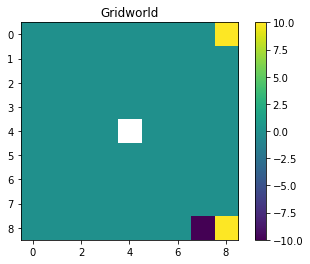

In [5]:
plt.imshow(gridworld, cmap="viridis")
plt.title("Gridworld")
plt.colorbar()

###  Probe of Transition Probabilities 

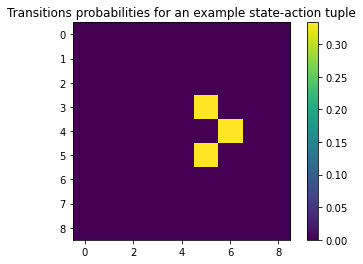

In [6]:
plt.imshow(T[4][5][2][:][:], cmap="viridis")
plt.title("Transitions probabilities for an example state-action tuple")
plt.colorbar()


### Probe of Reward Function

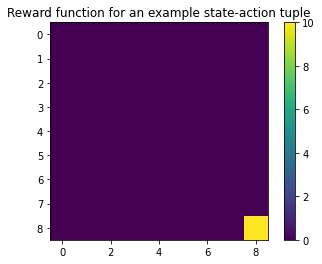

In [7]:
plt.imshow(R[8][7][3][:][:],cmap="viridis")
plt.title("Reward function for an example state-action tuple")
plt.colorbar()

# Value Iteration Algorithm with Maximum Entropy 

In [8]:
def policy_distribution_to_policy(policy_distribution):
    
    policy = np.empty(policy_distribution.shape[:2])
    
    for idx in range(policy_distribution.shape[0]):
        for jdx in range(policy_distribution.shape[1]):
            policy[idx][jdx] = np.argmax(policy_distribution[idx][jdx][:])
                      
    return policy
    

In [9]:
def value_iteration_max_ent(S,T,R,A,V,beta,discount_factor,num_iterations):
    
    #initialize the policy distribution
    #as a tensor of shape (S 0th dimension, S 1st dimension, num_actions)
    policy_distribution = np.zeros(tuple(list(S.shape)+list([A.shape[0]])))
    
    #initialize the Q function
    #as a tensor of shape (S 0th dimension, S 1st dimension, num_actions)
    Q = np.zeros(tuple(list(S.shape)+list([A.shape[0]])))
    
    
    
    #initialize the partition function Z  
    ############ 
    # for the current state
    #\sum_{a} exp \left( \frac{1}{\beta}r(s,a) \right)
                
    Z = np.zeros(S.shape)
    Z_tot = 0
    
    
    for idx in range(S.shape[0]):
        for jdx in range(S.shape[1]):
          
            #iterate over actions
            for adx,action in enumerate(A):
                if idx+action[0] < 0 or idx+action[0] >= S.shape[0]:
                    continue 
                if jdx+action[0] < 0 or jdx+action[1] >= S.shape[1]:
                        continue
                        
                        
                #iterate over target states accessible via the actions
                # (including unintended states due to transition probabilities)
                for bction in A:
                        if idx+bction[0] < 0 or idx+bction[0] >= S.shape[0]:
                            continue 
                        if jdx+bction[0] < 0 or jdx+bction[1] >= S.shape[1]:
                            continue                       
                        
                        Z[idx][jdx] += np.exp((1.0/beta)*R[idx][jdx][adx][idx+bction[0]][jdx + bction[1]])
                        
                        Z_tot += np.exp((1.0/beta)*R[idx][jdx][adx][idx+bction[0]][jdx + bction[1]])
                            
    
    ########## main algorithm
    
    for hdx in range(num_iterations):
        
        #initialize next values
        V_next = np.zeros(V.shape)
        policy_next = np.zeros(policy_distribution.shape)
        
        #for all states
        for idx in range(S.shape[0]):
            for jdx in range(S.shape[1]):
                
                
                ###############  update the Q function 
                #E \left [ r(s,a) + V_{i}(s') \right] = E[r(s,a)] + E[V_{i}(s')]
                
                
                #iterate over actions
                for adx,action in enumerate(A):
                    if idx+action[0] < 0 or idx+action[0] >= S.shape[0]:
                        continue 
                    if jdx+action[0] < 0 or jdx+action[1] >= S.shape[1]:
                        continue 
                        
                    Q[idx][jdx][adx] = 0
                    
                    maxQ = float(-np.inf)
                    
                    num_transitions =0
                        
                    #iterate over target states accessible via the actions
                    # (including unintended states due to transition probabilities)
                    for bction in A:
                        if idx+bction[0] < 0 or idx+bction[0] >= S.shape[0]:
                            continue 
                        if jdx+bction[0] < 0 or jdx+bction[1] >= S.shape[1]:
                            continue 
                        
                        Q[idx][jdx][adx] += (T[idx][jdx][adx][idx+bction[0]][jdx + bction[1]])*\
                                             (R[idx][jdx][adx][idx+bction[0]][jdx + bction[1]] + \
                                              discount_factor*V[idx+bction[0]][jdx + bction[1]])
                        
                        maxQ = max(maxQ,Q[idx][jdx][adx])
                        
                        
                    
                ############ update the V function
                # for the current state
                # \beta \text{log} \sum_{a} exp(\frac{1}{\beta} Q_{i+1}(s,a))
                
                V_sum = 0
                
                #iterate over actions
                for adx,action in enumerate(A):
                    if idx+action[0] < 0 or idx+action[0] >= S.shape[0]:
                        continue 
                    if jdx+action[0] < 0 or jdx+action[1] >= S.shape[1]:
                        continue
                        
                    V_sum+=  np.exp((1.0/beta)*(Q[idx][idx][adx]-maxQ))
                    
                V_next[idx][jdx] = beta*np.log(V_sum) + maxQ
                
                
                
                ############ update the policy distribution
                # for the current state
                # \frac{1}{Z} exp \left( \frac{1}{\beta} Q_{k}(s,a)  \right)
                
                #iterate over actions
                for adx,action in enumerate(A):
                    if idx+action[0] < 0 or idx+action[0] >= S.shape[0]:
                        continue 
                    if jdx+action[0] < 0 or jdx+action[1] >= S.shape[1]:
                        continue 
                            
                    policy_next[idx][jdx][adx] = (1.0/Z[idx][jdx])* np.exp((1.0/beta)*(Q[idx][jdx][adx]- maxQ))
                    
                normalization = np.sum(policy_next[idx][jdx][:])
                    
                policy_next[idx][jdx][:]/=normalization 
                
                  
        V = V_next 
        policy_distribution = policy_next
        
        
                
    return policy_distribution_to_policy(policy_distribution), V

In [10]:
policy, V_out = value_iteration_max_ent(gridworld,T,R,A,V,beta,discount_factor,1000)

# Solution

##  Value Map of the Gridworld

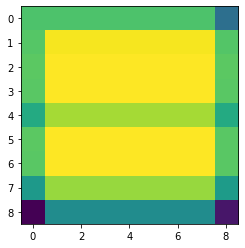

In [11]:
plt.imshow(V_out)

## Policy Map of the Gridworld

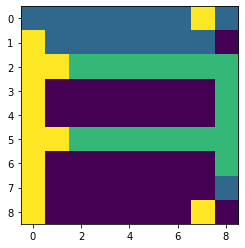

In [12]:
plt.imshow(policy)

# References

[1] https://people.eecs.berkeley.edu/~pabbeel/cs287-fa19/slides/Lec2-mdps-exact-methods.pdf

[2] https://www.andrew.cmu.edu/course/10-403/slides/S19maxentRL.pdf

[3] https://github.com/ordicker/cs287/blob/master/cs287hw1/cs287-hw1-code/part1/tabular_value_iteration.py

[4] https://julien-vitay.net/deeprl/EntropyRL.html